<a href="https://colab.research.google.com/github/kmoy14-stanford/AA203-Homework/blob/master/HW3/problem_1/reachability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Dependencies:
- System: python3, ffmpeg (for rendering animations)
- Python: jupyter, jax, numpy, matplotlib, plotly, tqdm, hj_reachability

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
sudo apt install ffmpeg
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter jax jaxlib numpy matplotlib plotly tqdm
pip install --upgrade git+https://github.com/StanfordASL/hj_reachability
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/StanfordASL/AA203-Homework/blob/master/HW3/problem_1/reachability.ipynb) and run a cell containing this command:
```
!pip install --upgrade git+https://github.com/StanfordASL/hj_reachability
```

In [ ]:
!pip install --upgrade git+https://github.com/StanfordASL/hj_reachability

  Cloning https://github.com/StanfordASL/hj_reachability to /tmp/pip-req-build-49_xgyue
  Running command git clone -q https://github.com/StanfordASL/hj_reachability /tmp/pip-req-build-49_xgyue
     |████████████████████████████████| 61kB 4.3MB/s 
  Created wheel for hj-reachability: filename=hj_reachability-0.2.0-cp37-none-any.whl size=18220 sha256=e24735366d9af1d748de332c235c2a70090e28107433744ed06b70bf4a6eaa51
  Stored in directory: /tmp/pip-ephem-wheel-cache-lw90752f/wheels/10/e0/1a/b4be1a3f7990de7e03da9c2f2ce39321c3b861c0ba49783214
Successfully built hj-reachability


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

import hj_reachability as hj

In [ ]:
# Define problem ingredients (exercise parts (a), (b), (c)).


class PlanarQuadrotor:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.Iyy = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        self.Cd_v = 0.25       # translational drag coefficient
        self.Cd_phi = 0.02255  # rotational drag coefficient
        # yapf: enable

        # Control constraints
        self.max_thrust_per_prop = 0.75 * self.m * self.g  # total thrust-to-weight ratio = 1.5
        self.min_thrust_per_prop = 0  # at least until variable-pitch quadrotors become mainstream :D

    def full_dynamics(self, full_state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, phi, omega = full_state
        T_1, T_2 = control
        return jnp.array([
            v_x,
            (-(T_1 + T_2) * jnp.sin(phi) - self.Cd_v * v_x) / self.m,
            v_y,
            ((T_1 + T_2) * jnp.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def dynamics(self, state, control):
        """Reduced (for the purpose of reachable set computation) continuous-time dynamics of a planar quadrotor."""
        y, v_y, phi, omega = state
        T_1, T_2 = control
        return jnp.array([
            v_y,
            ((T_1 + T_2) * jnp.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def optimal_control(self, state, grad_value):
        """Computes the optimal control realized by the HJ PDE Hamiltonian.
        
        Args:
            state: An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.
            grad_value: An array of shape `(4,)` containing the gradient of the value function at `state`.
        
        Returns:
            A vector of optimal controls, an array of shape `(2,)` containing `[T_1, T_2]`, that minimizes
            `grad_value @ self.dynamics(state, control)`.
        """
        # PART (a): WRITE YOUR CODE BELOW ###############################################
        # You may find `jnp.where` to be useful; see corresponding numpy docstring:
        # https://numpy.org/doc/stable/reference/generated/numpy.where.html
        y, v_y, phi, omega = state
        p1, p2, p3, p4 = grad_value

        a1 = p2 * jnp.cos(phi)/self.m - p4 * self.l/self.Iyy
        a2 = p4 * self.l/self.Iyy + p2 * jnp.cos(phi)/self.m
        T1 = jnp.where(a1 > 0, self.min_thrust_per_prop, self.max_thrust_per_prop)
        T2 = jnp.where(a2 > 0, self.min_thrust_per_prop, self.max_thrust_per_prop)
        opt_ctl = jnp.array([T1, T2])
        return opt_ctl
        #################################################################################

    def hamiltonian(self, state, time, value, grad_value):
        """Evaluates the HJ PDE Hamiltonian."""
        del time, value  # unused
        control = self.optimal_control(state, grad_value)
        return grad_value @ self.dynamics(state, control)

    def partial_max_magnitudes(self, state, time, value, grad_value_box):
        """Computes the max magnitudes of the Hamiltonian partials over the `grad_value_box` in each dimension."""
        del time, value, grad_value_box  # unused
        y, v_y, phi, omega = state
        return jnp.array([
            jnp.abs(v_y),
            (2 * self.max_thrust_per_prop * jnp.abs(jnp.cos(phi)) + self.Cd_v * jnp.abs(v_y)) / self.m + self.g,
            jnp.abs(omega),
            ((self.max_thrust_per_prop - self.min_thrust_per_prop) * self.l + self.Cd_phi * jnp.abs(omega)) / self.Iyy,
        ])


@jax.jit
def target_set(state):
    """A real-valued function such that the zero-sublevel set is the target set.
    
    Args:
        state: An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, nonnegative iff the state is in the target set.
    """
    # PART (b): WRITE YOUR CODE BELOW ###############################################
    y = state[0]
    v_y = state[1]
    phi = state[2]
    omega = state[3]
    h = jnp.max(jnp.array([y-7.0, -y+3.0, v_y-1.0, -v_y-1.0, phi-(np.pi/12), -phi-(np.pi/12), omega-1.0, -omega-1.0]))
    return h
    #################################################################################


@jax.jit
def envelope_set(state):
    """A real-valued function such that the zero-sublevel set is the operational envelope.
    
    Args:
        state: An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, nonnegative iff the state is in the operational envelope.
    """
    # PART (c): WRITE YOUR CODE BELOW ###############################################
    y = state[0]
    v_y = state[1]
    phi = state[2]
    omega = state[3]
    e = jnp.max(jnp.array([y-9.0, -y+1.0, v_y-6.0, -v_y-6.0, phi-(np.inf), -phi-(np.inf), omega-8.0, -omega-8.0]))
    return e
    #################################################################################


def test_optimal_control(n=10, seed=0):
    planar_quadrotor = PlanarQuadrotor()
    optimal_control = jax.jit(planar_quadrotor.optimal_control)
    np.random.seed(seed)
    states = 5 * np.random.normal(size=(n, 4))
    grad_values = np.random.normal(size=(n, 4))
    try:
        for state, grad_value in zip(states, grad_values):
            opt_hamiltonian_value = grad_value @ planar_quadrotor.dynamics(state, optimal_control(state, grad_value))
            for T_1 in (planar_quadrotor.min_thrust_per_prop, planar_quadrotor.max_thrust_per_prop):
                for T_2 in (planar_quadrotor.min_thrust_per_prop, planar_quadrotor.max_thrust_per_prop):
                    hamiltonian_value = grad_value @ planar_quadrotor.dynamics(state, np.array([T_1, T_2]))
                    if opt_hamiltonian_value > hamiltonian_value + 1e-4:
                        raise ValueError(
                            "Check your logic for `PlanarQuadrotor.optimal_control`; with "
                            f"`state` {state} and `grad_value` {grad_value}, got optimal control"
                            f"{optimal_control(state, grad_value)} with corresponding Hamiltonian value "
                            f"{opt_hamiltonian_value:7.4f} but {np.array([T_1, T_2])} has a lower corresponding "
                            f"value {hamiltonian_value:7.4f}.")
    except (jax.errors.JAXTypeError, jax.errors.JAXIndexError, AssertionError) as e:
        print("`PlanarQuadrotor.optimal_control` must be implemented using only `jnp` operations; "
              "`np` may only be used for constants, "
              "and `jnp.where` must be used instead of native python control flow (`if`/`else`).")
        raise e


def test_target_set():
    try:
        in_states = [
            np.array([5., 0., 0., 0.]),
            np.array([6., .1, .1, .1]),
            # feel free to add test cases
        ]
        out_states = [
            np.array([2., 0., 0., 0.]),
            np.array([5., 2., 0., 0.]),
            np.array([5., 0., 2., 0.]),
            np.array([5., 0., 0., 2.]),
            # feel free to add test cases
        ]
        for x in in_states:
            if target_set(x) > 0:
                raise ValueError(
                    f"Check your logic for `target_set`; for `state` {x} (in) you have target_set(state) = "
                    f"{target_set(x)}.")
        for x in out_states:
            if target_set(x) < 0:
                raise ValueError(
                    f"Check your logic for `target_set`; for `state` {x} (out) you have target_set(state) = "
                    f"{target_set(x)}.")
    except (jax.errors.JAXTypeError, jax.errors.JAXIndexError, AssertionError) as e:
        print("`target_set` must be implemented using only `jnp` operations, "
              "`np` may only be used for constants, "
              "and `jnp.where` must be used instead of native python control flow (`if`/`else`).")
        raise e


def test_envelope_set():
    try:
        in_states = [
            np.array([5., 0., 0., 0.]),
            np.array([7., 5., 100., 6.]),
            # feel free to add test cases
        ]
        out_states = [
            np.array([0., 0., 0., 0.]),
            np.array([5., 8., 0., 0.]),
            np.array([5., 0., 0., 10.]),
            # feel free to add test cases
        ]
        for x in in_states:
            if envelope_set(x) > 0:
                raise ValueError(
                    f"Check your logic for `envelope_set`; for `state` {x} (in) you have envelope_set(state) = "
                    f"{envelope_set(x)}.")
        for x in out_states:
            if envelope_set(x) < 0:
                raise ValueError(
                    f"Check your logic for `envelope_set`; for `state` {x} (out) you have envelope_set(state) = "
                    f"{envelope_set(x)}.")
    except (jax.errors.JAXTypeError, jax.errors.JAXIndexError, AssertionError) as e:
        print("`envelope_set` must be implemented using only `jnp` operations, "
              "`np` may only be used for constants, "
              "and `jnp.where` must be used instead of native python control flow (`if`/`else`).")
        raise e



test_optimal_control()
test_target_set()
test_envelope_set()

In [ ]:
# Set up problem for use with PDE solver.
planar_quadrotor = PlanarQuadrotor()
state_domain = hj.sets.Box(lo=np.array([0., -8., -np.pi, -10.]), hi=np.array([10., 8., np.pi, 10.]))
grid_resolution = (25, 25, 30, 25)  # can/should be increased if running on GPU, or if extra patient
grid = hj.Grid.from_grid_definition_and_initial_values(state_domain, grid_resolution, periodic_dims=2)

target_values = hj.utils.multivmap(target_set, np.arange(4))(grid.states)
envelope_values = hj.utils.multivmap(envelope_set, np.arange(4))(grid.states)
terminal_values = np.maximum(target_values, envelope_values)

solver_settings = hj.SolverSettings.with_accuracy(
    "medium",  # can/should be changed to "very_high" if running on GPU, or if extra patient
    hamiltonian_postprocessor=lambda x: jnp.minimum(x, 0),
    value_postprocessor=lambda t, x: jnp.maximum(x, envelope_values))

In [ ]:
# Propagate the HJ PDE _backwards_ in time.
initial_time = 0.
final_time = -5.
values = hj.step(solver_settings, planar_quadrotor, grid, initial_time, terminal_values, final_time).block_until_ready()
grad_values = grid.grad_values(values)

100%|##########|  5.0000/5.0 [02:21<00:00, 28.39s/sim_s]


In [ ]:
# Relevant contents of animations.py.
"""
Animations for various dynamical systems using `matplotlib`.
Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation


def animate_planar_quad(t, x, y, θ, title_string=None):
    """Animate the planar quadrotor system from given position data.
    All arguments are assumed to be 1-D NumPy arrays, where `x`, `y`, and `θ`
    are the degrees of freedom of the planar quadrotor over time `t`.
    Example usage:
        import matplotlib.pyplot as plt
        from animations import animate_planar_quad
        fig, ani = animate_planar_quad(t, x, θ)
        ani.save('planar_quad.mp4', writer='ffmpeg')
        plt.show()
    """
    # Geometry
    rod_width = 2.
    rod_height = 0.15
    axle_height = 0.2
    axle_width = 0.05
    prop_width = 0.5 * rod_width
    prop_height = 1.5 * rod_height
    hub_width = 0.3 * rod_width
    hub_height = 2.5 * rod_height

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max = np.min(x), np.max(x)
    x_pad = (rod_width + prop_width) / 2 + 0.1 * (x_max - x_min)
    y_min, y_max = np.min(y), np.max(y)
    y_pad = (rod_width + prop_width) / 2 + 0.1 * (y_max - y_min)
    ax.set_xlim([x_min - x_pad, x_max + x_pad])
    ax.set_ylim([y_min - y_pad, y_max + y_pad])
    ax.set_aspect(1.)
    if title_string is not None:
        plt.title(title_string)

    # Artists
    rod = mpatches.Rectangle((-rod_width / 2, -rod_height / 2),
                             rod_width,
                             rod_height,
                             facecolor='tab:blue',
                             edgecolor='k')
    hub = mpatches.FancyBboxPatch((-hub_width / 2, -hub_height / 2),
                                  hub_width,
                                  hub_height,
                                  facecolor='tab:blue',
                                  edgecolor='k',
                                  boxstyle='Round,pad=0.,rounding_size=0.05')
    axle_left = mpatches.Rectangle((-rod_width / 2, rod_height / 2),
                                   axle_width,
                                   axle_height,
                                   facecolor='tab:blue',
                                   edgecolor='k')
    axle_right = mpatches.Rectangle((rod_width / 2 - axle_width, rod_height / 2),
                                    axle_width,
                                    axle_height,
                                    facecolor='tab:blue',
                                    edgecolor='k')
    prop_left = mpatches.Ellipse(((axle_width - rod_width) / 2, rod_height / 2 + axle_height),
                                 prop_width,
                                 prop_height,
                                 facecolor='tab:gray',
                                 edgecolor='k',
                                 alpha=0.7)
    prop_right = mpatches.Ellipse(((rod_width - axle_width) / 2, rod_height / 2 + axle_height),
                                  prop_width,
                                  prop_height,
                                  facecolor='tab:gray',
                                  edgecolor='k',
                                  alpha=0.7)
    patches = (rod, hub, axle_left, axle_right, prop_left, prop_right)
    for patch in patches:
        ax.add_patch(patch)
    trace = ax.plot([], [], '--', linewidth=2, color='tab:orange')[0]
    timestamp = ax.text(0.1, 0.9, '', transform=ax.transAxes)

    def animate(k, t, x, y, θ):
        transform = mtransforms.Affine2D().rotate_around(0., 0., θ[k])
        transform += mtransforms.Affine2D().translate(x[k], y[k])
        transform += ax.transData
        for patch in patches:
            patch.set_transform(transform)
        trace.set_data(x[:k + 1], y[:k + 1])
        timestamp.set_text('t = {:.1f} s'.format(t[k]))
        artists = patches + (trace, timestamp)
        return artists

    dt = t[1] - t[0]
    step = max(int(np.floor((1 / 30) / dt)), 1)  # max out at 30Hz for faster rendering
    ani = animation.FuncAnimation(fig,
                                  animate,
                                  t[::step].size,
                                  fargs=(t[::step], x[::step], y[::step], θ[::step]),
                                  interval=step * dt * 1000,
                                  blit=True)
    try:
        get_ipython()
        from IPython.display import HTML
        ani = HTML(ani.to_html5_video())
    except (NameError, ImportError):
        pass
    return fig, ani

In [ ]:
# Utilities for rolling out the optimal controls and visualizing.

@jax.jit
def optimal_step(full_state, dt):
    state = full_state[2:]
    grad_value = grid.interpolate(grad_values, state)
    control = planar_quadrotor.optimal_control(state, grad_value)
    return full_state + dt * planar_quadrotor.full_dynamics(full_state, control)


def optimal_trajectory(full_state, dt=1 / 100, T=5):
    full_states = [full_state]
    t = np.arange(T / dt) * dt
    for _ in t:
        full_states.append(optimal_step(full_states[-1], dt))
    return t, np.array(full_states)


def animate_optimal_trajectory(full_state, dt=1 / 100, T=5):
    t, full_states = optimal_trajectory(full_state, dt, T)
    value = grid.interpolate(values, full_state[2:])
    fig, anim = animate_planar_quad(t, full_states[:, 0], full_states[:, 2], full_states[:, 4], f"V = {value:7.4f}")
    return fig, anim

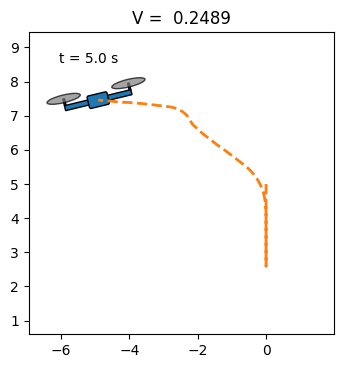

In [ ]:
# Dropping the quad straight down (v_y = -5, mimicking waiting for a sec after the drop to turn the props on).
state = [5., -5., 0., 0.]
animate_optimal_trajectory(np.array([0, 0] + state))[1]

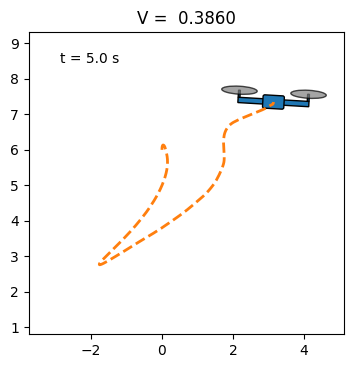

In [ ]:
# Flipping the quad up into the air.
state = [6., 2., -3 * np.pi / 4, -4.0]
animate_optimal_trajectory(np.array([0, 0] + state))[1]

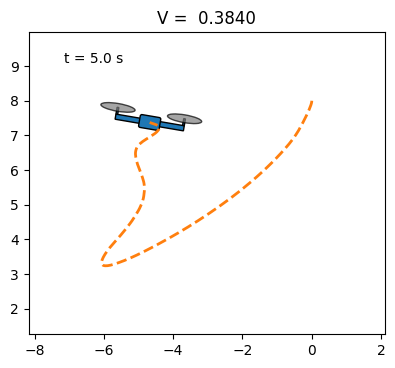

In [ ]:
# Dropping the quad like a falling leaf.
state = [8., -1., np.pi / 2, 2.]
animate_optimal_trajectory(np.array([0, 0] + state))[1]

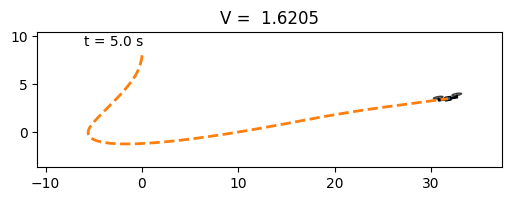

In [ ]:
# Too much negative vertical velocity to recover before hitting the floor.
state = [8., -3., np.pi / 2, 2.]
animate_optimal_trajectory(np.array([0, 0] + state))[1]

In [ ]:
# Examining an isosurface (exercise part (d)).
import plotly.graph_objects as go

i_y = 18
go.Figure(data=go.Isosurface(x=grid.states[i_y, ..., 1].ravel(),
                             y=grid.states[i_y, ..., 2].ravel(),
                             z=grid.states[i_y, ..., 3].ravel(),
                             value=values[i_y].ravel(),
                             colorscale="jet",
                             isomin=0,
                             surface_count=1,
                             isomax=0),
          layout_title=f"Zero isosurface, y = {grid.coordinate_vectors[0][i_y]:7.4f}",
          layout_scene_xaxis_title="v_y",
          layout_scene_yaxis_title="phi",
          layout_scene_zaxis_title="omega")